In [1]:
.libPaths()

[1] "/root/miniconda3/envs/Rdoc/lib/R/library"

In [2]:
library(monocle)

Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 4.2.3"
Loading required package: Biobase

Warning message:
"package 'Biobase' was built under R version 4.2.3"
Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages

In [3]:
setwd('/import/DB/zhang//data')

In [5]:
load('./final_Bcell.rda')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



In [6]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
Attaching SeuratObject



In [63]:
table(SCE$group,SCE$celltype)

         
          B_gc B_navie Plasma
  OS         0     266      0
  control  665    1419    856

In [76]:
Idents(SCE) = 'group'

In [87]:
sce = subset(SCE,idents = 'control')

In [88]:
bb = sce

In [89]:
library(dplyr)
library(RColorBrewer)
Idents(bb) = 'seurat_clusters'
DefaultAssay(bb) ='RNA'
data <- as(as.matrix(bb@assays$RNA@counts), 'sparseMatrix')
pd <- new('AnnotatedDataFrame', data = bb@meta.data)
fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
fd <- new('AnnotatedDataFrame', data = fData)
#Construct monocle cds
monocds <- newCellDataSet(data,
                              phenoData = pd,
                              featureData = fd,
                              lowerDetectionLimit = 0.5,
                              expressionFamily = negbinomial.size())

print("format data done , filter select genes ")
#pData(monocds)$Cluster<-as.factor(pData(monocds)$celltype) 
pData(monocds)['Cluster']=bb@active.ident	
monocds <- estimateSizeFactors(monocds)
monocds <- estimateDispersions(monocds)

[1] "format data done , filter select genes "


Removing 253 outliers



In [113]:
cds = monocds

In [114]:
outdaa = sce

In [115]:
sce

An object of class Seurat 
18983 features across 2940 samples within 1 assay 
Active assay: RNA (18983 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [93]:
# disp_table <- dispersionTable(cds)
# disp.genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)$gene_id
# cds <- setOrderingFilter(cds, disp.genes)

In [94]:
# var.genes <- VariableFeatures(outdaa)
# cds <- setOrderingFilter(cds, var.genes)

In [116]:
DefaultAssay(outdaa) = 'RNA'
Idents(outdaa) = 'seurat_clusters'
deg.cluster <- FindAllMarkers(outdaa)
diff.genes <- subset(deg.cluster,p_val_adj<0.05)$gene
cds <- setOrderingFilter(cds, diff.genes)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2



In [117]:
# cds <- detectGenes(cds, min_expr = 0.1)

# print(head(fData(cds)))
# expressed_genes <- row.names(subset(fData(cds), num_cells_expressed >= 30)) # nolint
# cds <- cds[expressed_genes, ]

# disp_table <- dispersionTable(cds)
# unsup_clustering_genes <- subset(
# disp_table, mean_expression >= 0.05 &
#   dispersion_empirical >= 1 * dispersion_fit
# ) #

# cds <- setOrderingFilter(cds, unsup_clustering_genes$gene_id)

### 修改形状的参数 链接 https://cloud.tencent.com/developer/article/2056834

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."


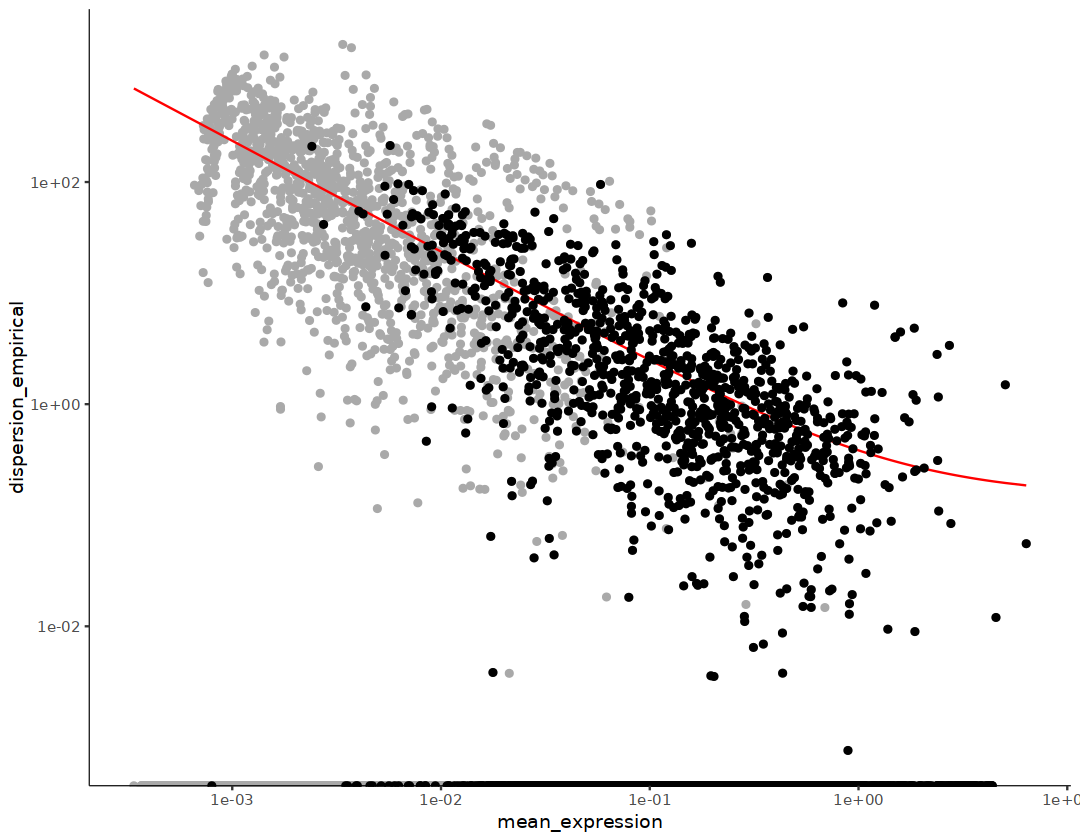

In [118]:
plot_ordering_genes(cds) 

In [119]:
cds <- reduceDimension(cds, max_components = 2, residualModelFormulaStr = "~sample", #去除样本影响
                       verbose = F, num_dim = 2, 
                       reduction_method = 'DDRTree')   # 修改method 为 reduction_method
cds <- orderCells(cds)

Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"
Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"


In [120]:
options(repr.plot.width = 9)

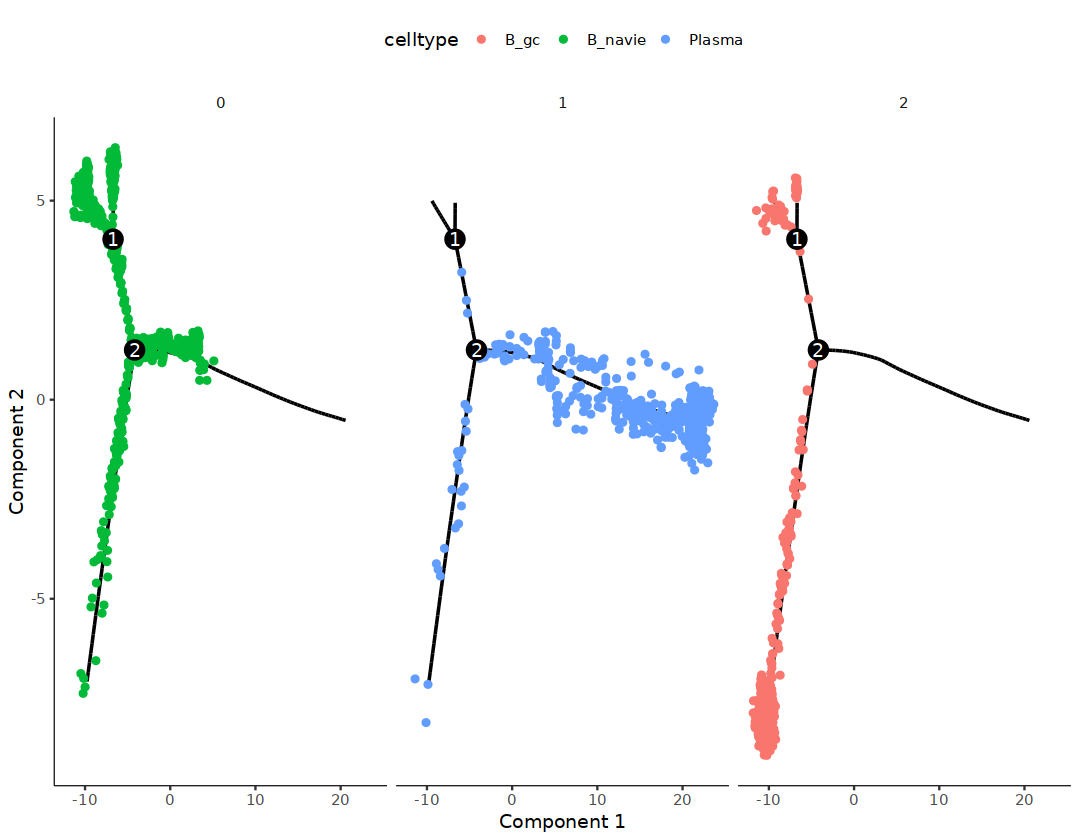

In [121]:
plot_cell_trajectory(cds, color_by = "celltype")+
  facet_wrap(~seurat_clusters, nrow = 1)

Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"
Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"


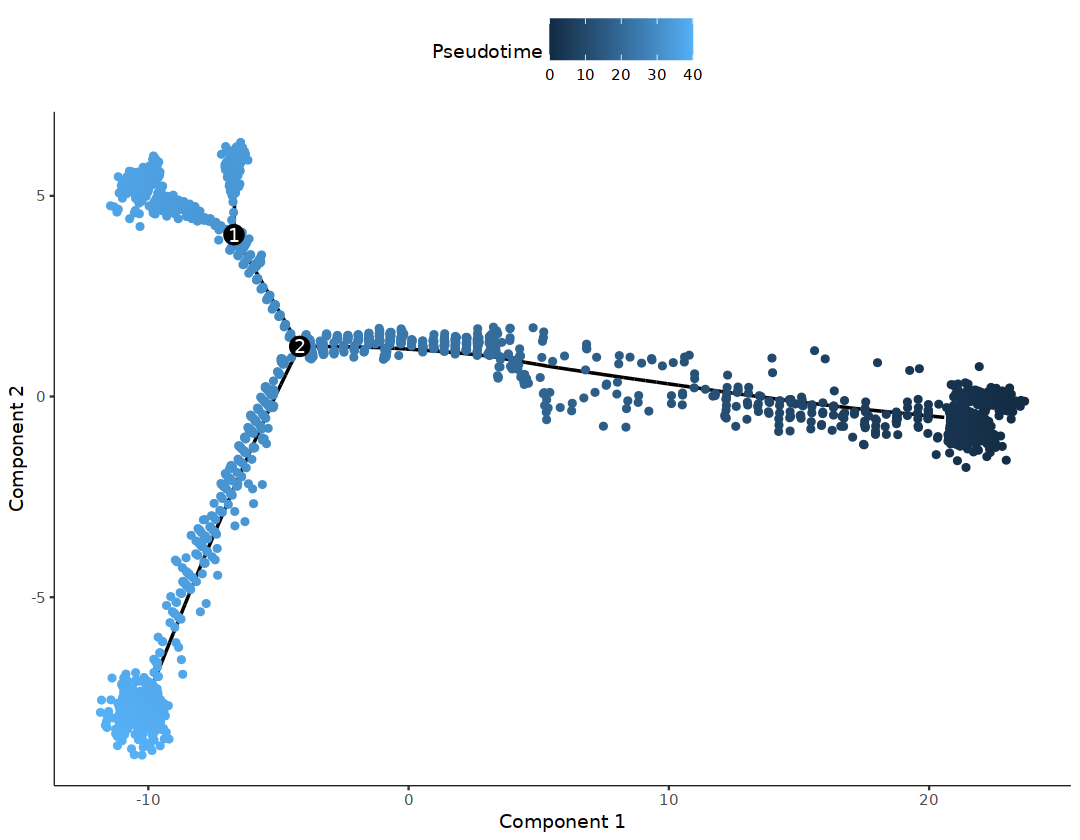

In [122]:
GM_state <- function(cds){
  if (length(unique(pData(cds)$State)) > 1){
    T0_counts <- table(pData(cds)$State, pData(cds)$seurat_clusters)[,"1"]
    return(as.numeric(names(T0_counts)[which
                                       (T0_counts == max(T0_counts))]))
  } else {
    return (1)
  }
}
HSMM_1 <- orderCells(cds, root_state = GM_state(cds))
plot_cell_trajectory(HSMM_1, color_by = "Pseudotime")

In [123]:
cds = HSMM_1

In [124]:
length(unsup_clustering_genes$gene_id)

[1] 384

In [125]:
Time_genes = unsup_clustering_genes$gene_id

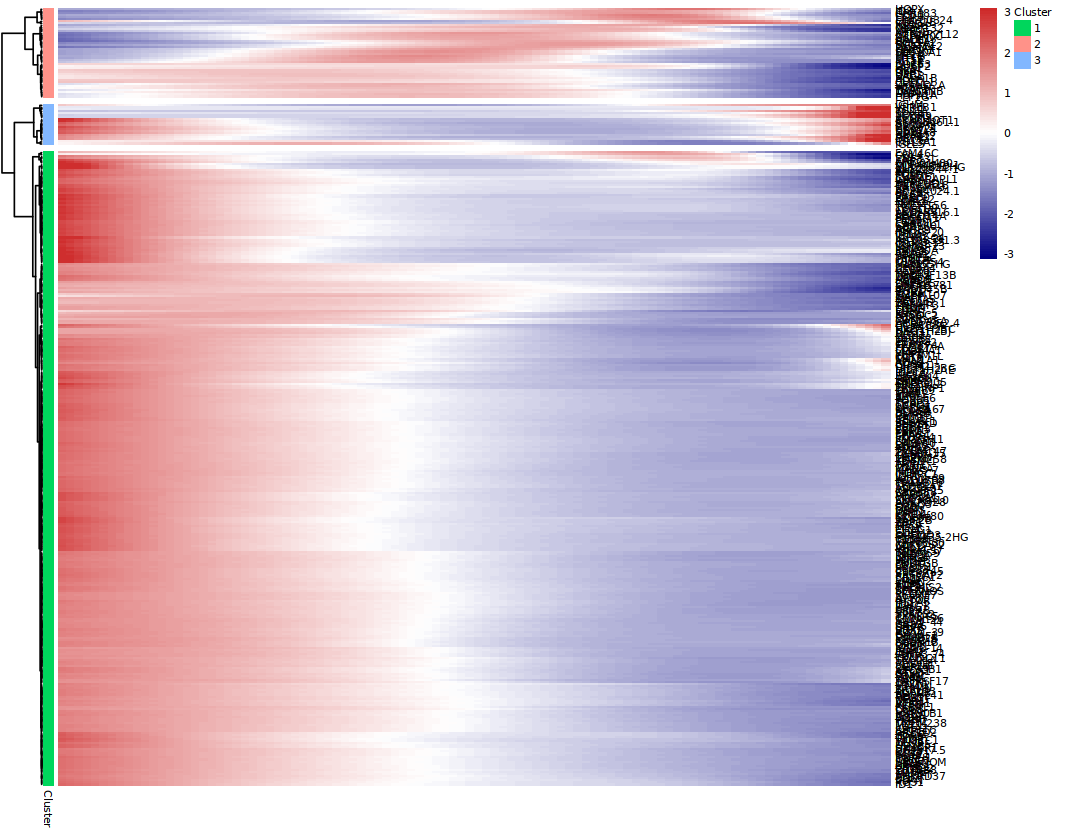

In [126]:
p = plot_pseudotime_heatmap(cds[Time_genes,], 
                             num_cluster = 3, 
                             show_rownames = T, 
                             return_heatmap = T,
                             hmcols = colorRampPalette(c("navy","white","firebrick3"))(100))


In [127]:
clusters <- cutree(p$tree_row, k = 3)
clustering <- data.frame(clusters)
clustering[,1] <- as.character(clustering[,1])
colnames(clustering) <- "Gene_Clusters"
table(clustering)

Gene_Clusters
  1   2   3 
312  44  20 

In [128]:
c3.gene = clustering %>%  filter(Gene_Clusters ==1) %>%  rownames()

In [129]:
save(cds,Time_genes,file = 'Bcell.monocle.rda')

In [130]:
library(clusterProfiler)
library(org.Hs.eg.db)

In [131]:
Gene_ID <- bitr(c3.gene, fromType="SYMBOL", 
            toType="ENTREZID", 
            OrgDb="org.Hs.eg.db")

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(c3.gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
"5.45% of input gene IDs are fail to map..."


In [132]:
gene <- Gene_ID[,2]
CC <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Hs.eg.db,  #物种对应的org包
               ont = "BP",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 1,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)  #

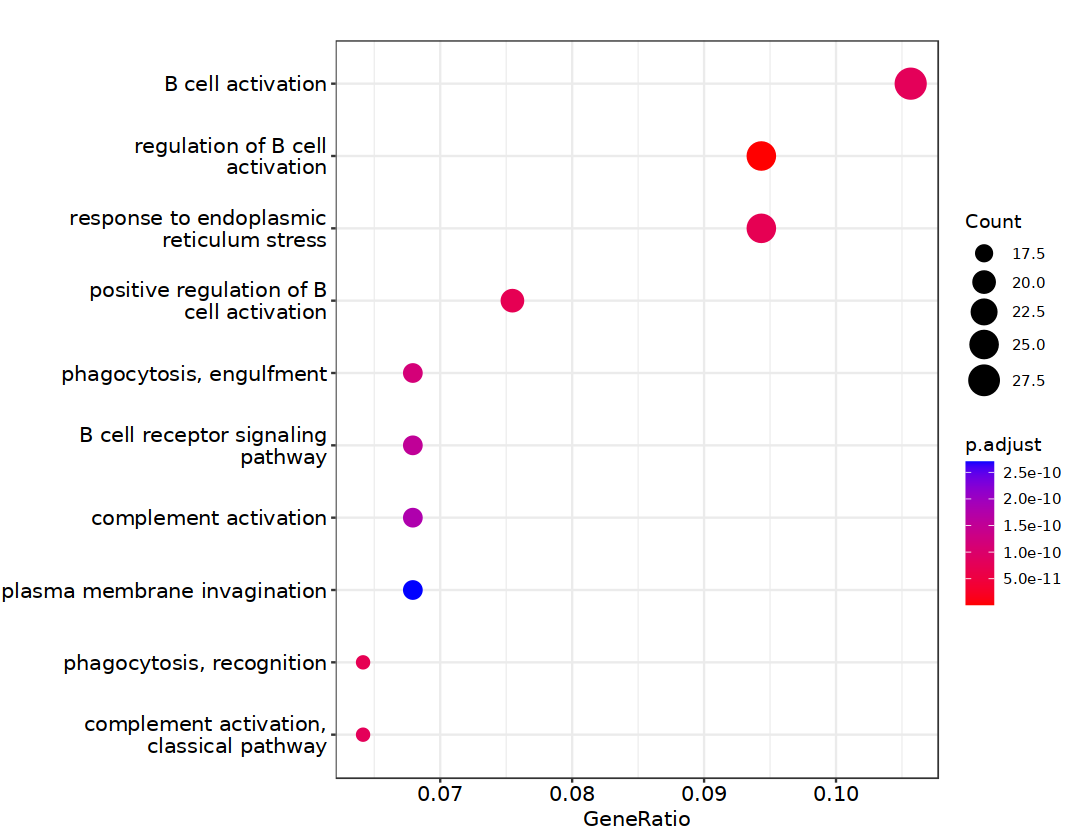

In [133]:
dotplot(CC)